#Assignment-2
#Facial Classification through Deep Learning


##Uploading Kaggle Json file to Use Kaggle Dataset Download API Command
You can get yours from Kaggle->Profile->Account->API->Create New Token

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ateebahmad","key":"f5df25d3e20074fa692b59d153b472a6"}'}

##Moving the Json file to Kaggle folder

In [8]:
!rm -r ~/.kaggle # Removing any existing kaggle directory
!mkdir ~/.kaggle # Creating new directory
!mv ./kaggle.json ~/.kaggle/ # Moving the Json file to Kaggle directory
!chmod 600 ~/.kaggle/kaggle.json # Changing the permission to only owner can access and read it

##Downloading the Dataset from Kaggle and Unzipping it

In [9]:
!kaggle competitions download -c face-classification-deep-learning-cs-405

100% 1.42G/1.42G [01:09<00:00, 23.8MB/s]
100% 1.42G/1.42G [01:09<00:00, 21.9MB/s]


In [10]:
%%capture
!unzip /content/face-classification-deep-learning-cs-405.zip;

##Importing Necessary Libraries

In [11]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
import pandas as pd
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

##Finding Size of the Image

In [12]:
img = Image.open("dataset/train/n000002/0025_01.jpg")
print(img.size)

(224, 224)


##Creating Necessary Transformations

In [13]:
transformations = T.Compose([T.ToTensor(), T.Resize((128,128))])

##Loading Train DataSet through ImageFolder Function

In [14]:
data_set = torchvision.datasets.ImageFolder(root = "dataset/train")
data_set.transform = transformations

##Splitting Train DataSet into Training and Validation Sets

In [15]:
# Specifying Ratios of Train and Val split

train_ratio = int(0.70 * len(data_set)) # 70% data for training
val_ratio = int(0.30 * len(data_set)) # 30% data for validation

# Random Split of Dataset
trainset, valset = torch.utils.data.random_split(data_set, [train_ratio, val_ratio], generator=torch.Generator().manual_seed(42))

## Finding Mean and Standard Deviation for Normalization

In [19]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(dataloader):

      # Mean over batch, height and width, but not over the channels
      channels_sum += torch.mean(data, dim=[0,2,3])
      channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
      num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

dataloader = torch.utils.data.DataLoader(dataset=data_set, batch_size=64)
m,s = get_mean_and_std(dataloader)
print(m,"\n",s)

100%|██████████| 2188/2188 [04:48<00:00,  7.58it/s]


tensor([0.5116, 0.4026, 0.3518]) 
 tensor([0.3054, 0.2677, 0.2567])


## Creating Normalization Transformation

In [20]:
# Using calculated mean & std
mean = [0.5116, 0.4026, 0.3518]
std = [0.3054, 0.2677, 0.2567]

# We will apply these transformations only on val set
val_T = T.Compose([T.Normalize(mean = mean, std = std)])

# We will apply these transformations only on test set
test_T = T.Compose([transformations, T.Normalize(mean = mean, std = std)])

##Creating Augmentation Transformation only for Train Set

In [21]:
# We will apply these augmentations only on train set

train_T = T.Compose([
    val_T,
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(degrees=45),
    T.GaussianBlur(5)])

##Creating Custom Train Dataset

In [22]:
class TrainDataset(torch.utils.data.Dataset):

  def __init__(self, dataset, transformations = None):
    self.dataset = dataset
    self.transform = transformations

  # Returns length of the dataset
  def __len__(self):
    return len(self.dataset)

  # Function for getting an item from the dataset
  def __getitem__(self, index):

    img, output = self.dataset[index]

    # Applying transformations if provided
    if self.transform is not None:

      t_img = self.transform(img)

      # return transformed image and output
      return t_img, output

    return img, output

##Loading Train & Validation Datasets

In [23]:
train_set = TrainDataset(trainset, train_T)

val_set = TrainDataset(valset, val_T)

##Creating a Custom Test Dataset

In [24]:
class TestDataset(torch.utils.data.Dataset):

  def __init__(self, img_path, files, t):
    self.path = img_path
    self.imgs = files
    self.transform = t

  # Function to return length of testset
  def __len__(self):
    return len(self.imgs)

  # Function to get an image from dataset
  def __getitem__(self, index):

    img = Image.open(self.path + "/" + self.imgs[index-1])

    # Transforming the image
    t_img = self.transform(img)

    # Returning the transformed image and the name of image
    return t_img, imgs[index-1]

In [25]:
# Defining path for test folder
path = '/content/dataset/test'

imgs = []

# Storing the name of all images in test folder
for _, _, filenames in os.walk(path):
  imgs = filenames

# Creating testset from our custom dataset
test_set = TestDataset(path, imgs, test_T)

##Finding Classes of our dataset

In [26]:
# Print the classes in the dataset
classes = None

if hasattr(data_set, 'classes'):
  classes = data_set.classes

if hasattr(data_set, 'dataset') and hasattr(data_set.dataset, 'classes'):
  classes = data_set.dataset.classes

classes

['n000001',
 'n000002',
 'n000003',
 'n000004',
 'n000005',
 'n000008',
 'n000011',
 'n000012',
 'n000013',
 'n000014',
 'n000015',
 'n000016',
 'n000017',
 'n000018',
 'n000019',
 'n000020',
 'n000021',
 'n000022',
 'n000023',
 'n000024',
 'n000025',
 'n000026',
 'n000027',
 'n000029',
 'n000030',
 'n000031',
 'n000034',
 'n000035',
 'n000036',
 'n000037',
 'n000038',
 'n000040',
 'n000041',
 'n000042',
 'n000043',
 'n000044',
 'n000045',
 'n000046',
 'n000047',
 'n000048',
 'n000049',
 'n000050',
 'n000051',
 'n000052',
 'n000053',
 'n000054',
 'n000055',
 'n000056',
 'n000057',
 'n000058',
 'n000059',
 'n000060',
 'n000061',
 'n000062',
 'n000063',
 'n000066',
 'n000067',
 'n000068',
 'n000069',
 'n000070',
 'n000071',
 'n000074',
 'n000075',
 'n000077',
 'n000079',
 'n000082',
 'n000084',
 'n000085',
 'n000086',
 'n000088',
 'n000089',
 'n000090',
 'n000091',
 'n000092',
 'n000093',
 'n000094',
 'n000095',
 'n000096',
 'n000097',
 'n000098',
 'n000100',
 'n000101',
 'n000106',
 'n0

##Creating Data Loaders

In [27]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers = 4
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False
    #num_workers = 4
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=32,
    shuffle=False
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Building a Deep Face Classifier

In [28]:
class Classifier(nn.Module):

  def __init__(self, num_classes = 7000):

    super(Classifier, self).__init__() # Accessing the 'nn' super class

    # Defining Convolutional Layers for our Classifier:

    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride = 2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride = 2)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride = 2)
    )

    # Defining Fully Connected Layers for our Classifier:

    self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(16*16*64, 12288),
        nn.BatchNorm1d(12288),
        nn.ReLU()
    )

    self.fc2 = nn.Sequential(

        nn.Linear(12288, 12288),
        nn.BatchNorm1d(12288),
        nn.ReLU()
    )

    self.fc3 = nn.Sequential(

        nn.Linear(12288, num_classes)
    )


  def forward(self, x):

    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)

    out = self.fc1(out)
    out = self.fc2(out)
    yhat = self.fc3(out)

    return yhat

model = Classifier().to(device)
model

Classifier(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=12288

##Defining Optimizer & Loss Function

In [29]:
# Loss function
L = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, weight_decay = 0.01)

##Training & Validation

In [30]:
def train_or_val(model, optimizer, dataloader, train):

  if train:
    model.train()
  else:
    model.eval()

  running_loss = 0
  correct = 0
  accumulation = 4 # Gradient accumulation

  for batches, (x, y) in enumerate(tqdm(dataloader)):

    x, y = x.to(device), y.to(device) # assign input samples to the available device (CPU or GPU) for computation.

    # Forward Pass
    yhat = model(x)

    # Computing loss
    loss = L(yhat, y)
    running_loss += loss.item()

    # Backpropogation
    if train:
      loss.backward() # Calculating gradients

      # Using gradient accumulation technique
      if (batches + 1) % accumulation == 0:
        optimizer.step() # Updating weights and biases
        optimizer.zero_grad() # Making gradient equal to zero to avoid accumulation

    correct += (yhat.argmax(1) == y).sum().item()

  loss = running_loss/len(dataloader)
  accuracy = correct/len(dataloader.dataset) * 100

  return loss, accuracy

##Mounting Google Drive for Ease of Downloading & Uploading Checkpoints

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Defining Paths for Checkpointing

In [32]:
checkpoint_path = '/content/drive/MyDrive/DL_Assignment2/checkpoint.pth'
best_checkpoint_path = '/content/drive/MyDrive/DL_Assignment2/best_checkpoint.pth'

##Monitoring the Performance

In [33]:
def model_training(model, start, optimizer, train_loader, val_loader, max_accuracy, train, not_train):

  Epochs = 150
  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []

  for i in range(start, Epochs):

    print(f"Epoch {i + 1}: Train")
    t_loss, t_accuracy = train_or_val(model, optimizer, train_loader, train)

    train_losses.append(t_loss)
    train_accuracies.append(t_accuracy)

    print(f"Epoch {i + 1}: Validation")
    v_loss, v_accuracy = train_or_val(model, optimizer, val_loader, not_train)

    val_losses.append(v_loss)
    val_accuracies.append(v_accuracy)

    # Storing Information of each epoch for checkpointing
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epochs": i + 1,
        "accuracy": v_accuracy,
        "learning Rate": optimizer.param_groups[0]["lr"],
        "Max Accuracy": max_accuracy
        }

    print(f"\nTrain Loss: {t_loss:>0.3f}  Train Accuracy: {t_accuracy:>0.2f}%")
    print(f"Val Loss: {v_loss:>0.3f}  Val Accuracy: {v_accuracy:>0.2f}%")

    if v_accuracy > max_accuracy:
      print(f"New Max Val Accuracy of {v_accuracy:>0.2f}% Reached. Saving Model...\n")
      max_accuracy = v_accuracy

      # Storing Checkpoint Information of best epoch
      torch.save(checkpoint, best_checkpoint_path)

    else:
      print(f"Val Accuracy did not increase from {max_accuracy:>0.2f}%\n")

    # Storing Checkpoint Information of last epoch
    torch.save(checkpoint, checkpoint_path)

  # returning losses and accuracies
  return train_losses, train_accuracies, val_losses, val_accuracies

# Starting Training
start_epoch = 0
max_accuracy = -1

train_loss, train_accuracy, val_loss, val_accuracy = model_training(model, start_epoch, optimizer, train_loader, val_loader, max_accuracy, True, False)

#Resuming Training Using Checkpointing

##Loading Last Checkpoint

In [34]:
# Loading Checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))

# Loading the states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epochs']
accuracy = checkpoint['Max Accuracy']

##Resuming Training

In [35]:
# Resuming Training
train_loss, train_accuracy, val_loss, val_accuracy = model_training(model, start_epoch, optimizer, train_loader, val_loader, accuracy, True, False)

##Plotting Graphs

In [ ]:
# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss, label="Validation")
plt.plot(train_loss, label="Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training and validation Accuracies.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy, label="Validation")
plt.plot(train_accuracy, label="Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Inferencing the Model

##Loading the Best Checkpoint

In [37]:
# Loading Checkpoint
checkpoint = torch.load(best_checkpoint_path, map_location=torch.device(device))

# Loading the state of model
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

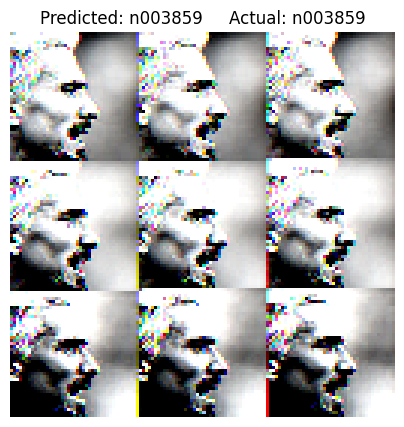

In [40]:
model.to("cpu")

# The sample you want to test
Sample = 1100 # # Keep sample between 0 and 42000

# Getting the required image
img = val_set[Sample][0]

model.eval()

img = img.view(-1, 3, 128, 128)

# Getting Output
with torch.no_grad():
  yhat = model(img)

# Getting predicted and actual outputs
pred, actual = classes[yhat.argmax(1)], classes[val_set[Sample][1]]

# Displaying Result
plt.figure(figsize=(5,5))
plt.title("Predicted: " + pred + "     Actual: " + actual)
plt.axis("off")
img = img.reshape((128, 128, 3))
plt.imshow(img)

#Creating Submission File

In [41]:
# Create an empty DataFrame with column names
df = pd.DataFrame(columns=['image_name', 'label'])

In [46]:
image_names = []
labels = []

for x,y in tqdm(test_loader):

  # Sending to GPU
  x = x.to(device)

  # Storing image names in a list
  image_names.extend(y)

  # Getting Predictions/labels
  yhat = model(x)

  # Getting labels in the required naming format
  label = [classes[x.argmax()] for x in yhat]
  labels.extend(label)

# Storing in the dataframe
df['image_name'] = image_names
df['label'] = labels

# Saving the DataFrame to the required CSV file
df.to_csv('submission.csv', index=False)

100%|██████████| 1094/1094 [02:02<00:00,  8.95it/s]


In [51]:
df

,image_name,label
0,8370.jpg,n004679
1,33227.jpg,n004067
2,33822.jpg,n007621
3,20592.jpg,n007529
4,23571.jpg,n001753
...,...,...
34995,20682.jpg,n007938
34996,10000.jpg,n005194
34997,938.jpg,n001131
34998,2729.jpg,n005253
